# Ergodicity Econ Codes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl

In [2]:
from scipy.optimize import minimize

## A simple gamle

Start with 1$ and play the following game:

- flip a coin (or simulate a 50/50 random number being zero or 1)
- with probability 1/2 add 40\% or subtract 30\% from the value, i.e. with probability 1/2 $x_{t+1} = x_t*(1+\eta)$ and with probability 1/2 $x_{t+1} = x_t*(1-\eta)$
- where $\eta$ is e.g. 0.2

## The ensemble average
The usual way to approach this is by taking the `ensemble average` between the time series generated through many simulations of the game. 

In [3]:
avg = np.ones([51,1001])
e_up = 0.4
e_down = 0.3

for j in range(0,50):
    for i in range(0,1000):
        rand = round(np.random.uniform(0,1))
        if rand == 0:
            avg[j+1][i] = avg[j][i]*(1-e_down)
        else:
            avg[j+1][i] = avg[j][i]*(1+e_up)  


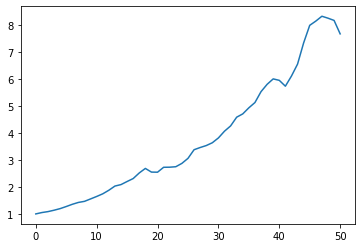

In [4]:
plt.plot(avg.mean(axis=1))

Having a closer look at the simulations reveals that this upwards trend is driven by only a handfull paths of the 1000 paths generated. 

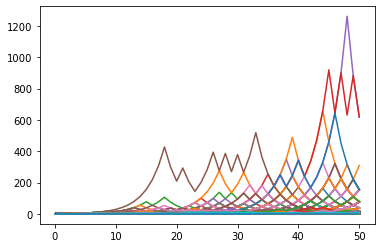

In [5]:
plt.plot(avg)
plt.show()

## The simple game over the long horizon
One way to get the average and get rid of variation is to observe the time series over a long time and compute the average $\frac{1}{T}\sum_{i=1}^{T}x_i$.

For this purpose we simulate the game over 1000 rounds to see what happens. 

In [6]:
v = np.array([1])
e_up = 0.4
e_down = 0.3

for i in range(0,100):
    rand = round(np.random.uniform(0,1))
    if rand == 0:
        newvalue = v[i]*(1-e_down)
        v = np.append(v, [newvalue])
    else:
        newvalue = v[i]*(1+e_up)
        v = np.append(v, [newvalue])

<function matplotlib.pyplot.show(close=None, block=None)>

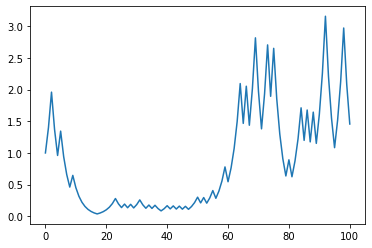

In [7]:
plt.plot(v)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

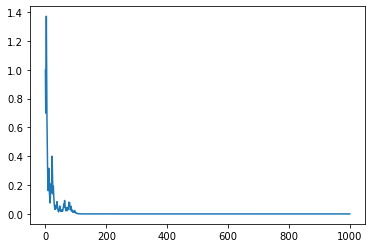

In [8]:
n = 1000
v = np.ones([n])
e_up = 0.4
e_down = 0.3

for i in range(1,n):
    rand = round(np.random.uniform(0,1))
    if rand == 0:
        v[i] = v[i-1]*(1-e_down)
    else:
        v[i] = v[i-1]*(1+e_up)


plt.plot(v)
plt.show     
        

The feature of this process is called `non ergodic`. Simply put, the time average and the ensemble average do not converge, i.e. become the same values for $N\rightarrow \infty$ and $T\rightarrow \infty$. The ensemble average can be thought of as looking at thousands of parallel worlds whereas the time average looks at what happens to a single path, or a single person like you and me, over the long run. 

# Portfolio Optimization
The above simple game motivates to look at the time average to better capture what happens to the average Joe's portfolio over time. 

## The process of our portfolio


We make use of a standard model from mathematical finance. We start off by assuming our assets follow a multiplicative dynamics which me model by a geometric brownian motion, which is arguably a random walk process for the continuous time. The amount of x invested in our portfolio evolves according to the stochastic differential equation: 

$$dx = x(\mu dt + \sigma dW)$$ 

where $\mu$ is the drift and $\sigma$ the volatility. The drift is known as the expected return since it is the growth rate of the expectation value of x. 


We can rewrite this as 

$$dx = a(x,t)dt + b(x,t)dW$$ 

and use Ito's formula: 

$$dv = \left( \frac{\delta v}{\delta t} + a(x,t)\frac{\delta v}{\delta x} + \frac{b(x,t)^2}{2}\frac{\delta^2 v}{\delta x^2} \right) dt + b(x,t)\frac{\delta v}{\delta x}dW $$ 

where we use $dv = dlnx$ for multiplicative process. The solution will be:

$$x(t_0 + \Delta t) = x(t_0)exp \left[ \left( \mu - \frac{\sigma^2}{2} \right) \Delta t  + \sigma W(\Delta t) \right]$$

From this results we compute the time average growth rate as the limit of the difference in $ln(x)$ divided by $\Delta t$ the change in time where t is going to infinity:

$$\bar{g} = \lim \limits_{\Delta t \to \infty} \left\{ \frac{\Delta ln(x)}{\Delta t} \right\} = \lim \limits_{\Delta t \to \infty} \left\{ \frac{1}{\Delta t} \left[ \left( \mu  - \frac{\sigma^2}{2} \right) \Delta t  + \sigma W(\Delta t) \right] \right\}$$

which converges to:

$$\bar{g} =  \mu - \frac{\sigma^2}{2} $$



Using the fact that the expectation of the square of the Wiener process (variance) is equal to T we can derive how long it takes until the difference between the time average and the ensemble average is visible.

$$t>t_{min} = \frac{\sigma^2}{\left(\mu - \frac{\sigma^2}{2}\right)^2}$$


## Optimal diversification 

Next, we turn to our well known Markowitz model to finally get to our simple model for selecting the portfolio weights. 

Remember from modern portfolio theory the expected return of portfolio p $ \mathbb{E} (R_p) = \sum_{i} w_i \mathbb{E} (R_i) $ is the sum of the weights of asset i times the expected return of asset i. As we know from before the expected return is $\mu_i$. Furthermore, the portfolio returns variance is defined as $\sigma^{2}_{p} = \sum_{i} \sum_{j} w_i w_j \sigma_{ij}$. 

Using these definitions we get a neat `utility function` if you will, the time average growth rate of our portfolio, which we can maximize with respect to the weigthts. 

$$U = \bar{g} = \mu^T \omega - \frac{\omega^T \Sigma \omega}{2} $$

Where $\omega$ is a vector of portfolio weights and $\mu$ is a vector of the drift terms. $\Sigma$ is the variance-covariance matrix of our assets. 

Maximizing with respect to the weights vector $\omega$ can be achieved by taking the first derivative and set it to zero. This gives us:

$$\omega = \mu^T\Sigma^{-1}$$

## Some Python code
Let's load some real stock data and see how we can come up with a portfolio that maximizes its growth rate based on our theory. 

In [3]:
quandl.ApiConfig.api_key =  'YOURAPIKEY'

start = '2013-01-01'
end = '2019-01-01'


# get just the Adj Close column of FB, AMZN, AAPL, IBM
fb = quandl.get('WIKI/FB.11', start_date=start, end_date=end)
amzn = quandl.get('WIKI/AMZN.11', start_date=start, end_date=end)
aapl = quandl.get('WIKI/AAPL.11', start_date=start, end_date=end)
ibm = quandl.get('WIKI/IBM.11', start_date=start, end_date=end)
# concatenate them and rename the columns
stocks = pd.concat([fb,amzn,aapl,ibm], axis=1)
stocks.columns = ['fb','amzn','aapl','ibm']

stocks.head()


,fb,amzn,aapl,ibm
Date,,,,
2013-01-02,28.0000,257.3100,71.195748,168.890592
2013-01-03,27.7700,258.4800,70.296565,167.961630
2013-01-04,28.7600,259.1500,68.338996,166.860637
2013-01-07,29.4213,268.4592,67.937002,166.129509
2013-01-08,29.0607,266.3800,68.119845,165.897268


Calculating the log returns 

In [6]:
log_return = np.log(stocks/stocks.shift(1)).dropna()
simple_return = ((stocks / stocks.shift(1))-1).dropna()

simple_return.head()

,fb,amzn,aapl,ibm
Date,,,,
2013-01-03,-0.008214,0.004547,-0.012630,-0.005500
2013-01-04,0.035650,0.002592,-0.027847,-0.006555
2013-01-07,0.022994,0.035922,-0.005882,-0.004382
2013-01-08,-0.012256,-0.007745,0.002691,-0.001398
2013-01-09,0.052624,-0.000113,-0.015629,-0.002852


Calculate the optimal weights as $$\omega = \mu^T\Sigma^{-1}$$

In [7]:
mu = log_return.mean()
sigma = log_return.cov()
sigma_inv = np.linalg.inv(sigma)

weights = np.dot(mu.T, sigma_inv)
weights

array([ 1.98774249,  3.179794  ,  1.58353978, -2.95079769])

In [8]:
def exp_r(w, data): 
    return np.sum(data.mean()*w)
    
def exp_vol(w, data): 
    return np.sqrt(np.dot(w.T, np.dot(data.cov(), w)))



print("expected return: ", exp_r(weights, log_return))
print("expected volatility: ", exp_vol(weights, log_return))

expected return:  0.008025390039758325
expected volatility:  0.089584541299034


Note that we did not constrain it in any way so that there are no negative weights. However, as a private person usually you do not want to go into negative positions. Therefore we will make use of the scipy optimizer where we can add the restriction of weights adding up to 1 and being non-zero. 

Making use of an optimization algorithm to add certain constraints. 

In [12]:
def inv_time_gr(w, data):
    return 1/(exp_r(w, data) - np.dot(w.T, np.dot(data.cov(), w))/2 )

def neg_sharpe(w, data):
    return (exp_r(w, data) / exp_vol(w, data))*-1

def check_sum(w):
    return np.sum(w)-1

# create constraing
cons = ({'type':'eq','fun':check_sum})

# create weight boundaries
bounds = ((0,1),(0,1),(0,1),(0,1))

# initial guess
init_guess = [0.25, 0.25, 0.25, 0.25]

opt_results = minimize(inv_time_gr ,init_guess, args=(simple_return), method='SLSQP', bounds=bounds, constraints=cons)
opt_results_trad = minimize(neg_sharpe, init_guess, args = (simple_return), method='SLSQP', bounds=bounds, constraints=cons)

In [13]:
opt_results

     fun: 732.6802393437281
     jac: array([-661.3715744 , -661.37158203, -360.32821655,   28.69963074])
 message: 'Optimization terminated successfully'
    nfev: 26
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([3.53841786e-01, 6.46158214e-01, 0.00000000e+00, 7.39311196e-11])

In [16]:
sigma = exp_vol(opt_results.x, simple_return)
sigma

0.016299399957715625

In [17]:
mu_optimal = exp_r(opt_results.x, simple_return)

In [19]:
sigma**2 / (exp_r([0.25,0.25,0.25,0.25] ,simple_return)- (sigma)**2 / 2)**2

413.03796597847634

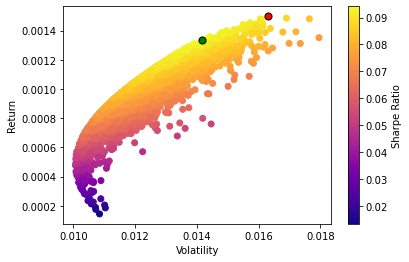

In [20]:
num_ports = 5000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports): 
    # weights 
    weights = np.array(np.random.random(4)) 
    weights = weights/np.sum(weights)  
    
    # save the weights
    all_weights[ind,:] = weights
    
    # expected return 
    ret_arr[ind] = np.sum(simple_return.mean()*weights)

    # expected volatility 
    vol_arr[ind] = np.sqrt(np.dot(weights.T,np.dot(simple_return.cov(), weights)))

    # Sharpe Ratio 
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]
    
    
# plot the dataplt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')    

plt.scatter(exp_vol(opt_results.x, simple_return), exp_r(opt_results.x, simple_return), c='red', s=50, edgecolors='black')
plt.scatter(exp_vol(opt_results_trad.x, simple_return), exp_r(opt_results_trad.x, simple_return), c='green', s=50, edgecolors='black')

In [27]:
t_avg = np.sum(opt_results.x*mu) - np.dot(opt_results.x.T, np.dot(sigma, opt_results.x))/2
trad = np.sum(opt_results_trad.x*mu) - np.dot(opt_results_trad.x.T, np.dot(sigma, opt_results_trad.x))/2

In [21]:
(np.sum(opt_results.x*mu) - np.dot(opt_results.x.T, np.dot(sigma, opt_results.x)))

-0.002765294670119379

## Backtest
We want to select the optimal portfolio weights based on the maximal Shapre and our new method and compare. The rebalancing is done every year. 

In [ ]:
#create rolling mean and rolling covariance functions

def exp_rolling_r(w, date, periods, data): 
    return np.sum(data.rolling(periods, min_periods = periods).mean().loc[date]*w)
    
def exp_rolling_vol(w, date, periods, data): 
    return np.sqrt(np.dot(w.T, np.dot(data.rolling(periods, min_periods = periods).cov().loc[date], w)))


def inv_time_gr_roll(w, date, periods, data):
    return 1/(np.sum(data.rolling(periods, min_periods = periods).mean().loc[date]*w) - np.dot(w.T, np.dot(data.rolling(periods, min_periods = periods).cov().loc[date], w))/2 )

def neg_sharpe_roll(w, date, periods, data):
    return (np.sum(data.rolling(periods, min_periods = periods).mean().loc[date]*w) / np.sqrt(np.dot(w.T, np.dot(data.rolling(periods, min_periods = periods).cov().loc[date], w))) )*-1

def check_sum(w):
    return np.sum(w)-1

# create constraing
cons = ({'type':'eq','fun':check_sum})

# create weight boundaries
bounds = ((0,1),(0,1),(0,1),(0,1))

# initial guess
init_guess = [0.25, 0.25, 0.25, 0.25]

opt_results = minimize(inv_time_gr_roll, init_guess, args = ('2018-03-01', 30 , simple_return), method='SLSQP', bounds=bounds, constraints=cons)

#opt_results_trad = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)


In [25]:
exp_rolling_r(opt_results.x ,'2018-03-01', 30 , simple_return)

0.004961436621006371

### Stability of the parameters
Plot the rolling mean and the rolling covariance. They don't seem very stable for the single stocks.

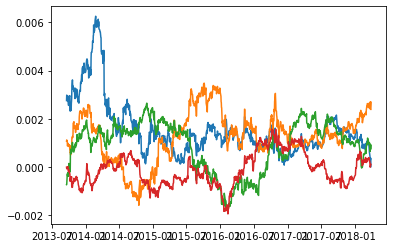

In [26]:
plt.plot(log_return.rolling(180, min_periods = 180).mean())

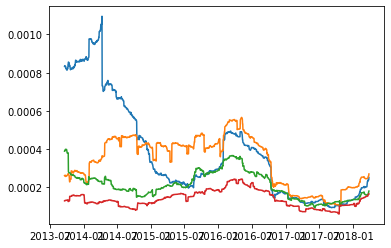

In [27]:
plt.plot(log_return.rolling(180, min_periods = 180).var())

## Use portfolios instead of stocks
As we saw before, our new method did perform better than the maximal sharpe strategy. However, 1/n still outperformed by a lot. Single stocks might have too of an unstable covariance and drift..

Next, we use the SPY (S&P500), IEF (treasury ETF), LQD (US investment grade bonds) and IEF (real estate ETF) to create a portfolio. 

In [4]:
assets= pd.read_csv("assets.csv", index_col = 'Date' )
assets.index = pd.to_datetime(assets.index)
assets.head()

,IYR,SPY,LQD,IEF
Date,,,,
2002-07-31,18.984459,63.154285,45.123825,47.255814
2002-01-08,18.721695,61.505451,45.566280,47.450462
2002-02-08,18.310438,60.126820,45.659218,47.817020
2002-05-08,17.995127,58.034615,45.548592,48.057537
2002-06-08,18.040829,59.988262,45.393723,47.668110


In [5]:
log_return_a = np.log(assets/assets.shift(1)).dropna()
simple_return_a = ((assets / assets.shift(1))-1).dropna()


simple_return_a.head()


,IYR,SPY,LQD,IEF
Date,,,,
2002-01-08,-0.013841,-0.026108,0.009805,0.004119
2002-02-08,-0.021967,-0.022415,0.002040,0.007725
2002-05-08,-0.017220,-0.034797,-0.002423,0.005030
2002-06-08,0.002540,0.033663,-0.003400,-0.008103
2002-07-08,0.020770,0.017439,0.002826,0.003124


In [6]:
cum_ret = log_return_a.cumsum() # summing up to get cumulative log return
cum_ret = np.exp(cum_ret)-1 # change it again to simple returns 
cum_ret.tail()

,IYR,SPY,LQD,IEF
Date,,,,
2021-05-04,3.948785,5.434401,1.880297,1.392087
2021-06-04,3.961953,5.430601,1.899577,1.403725
2021-07-04,3.961953,5.438043,1.893815,1.402244
2021-08-04,3.949838,5.468603,1.904452,1.410497
2021-09-04,3.949311,5.515631,1.898469,1.404149


In the following we generate three empty columns, set the window lenght and the time after we rebalance (252 is about one year, since we have trading days and not calendar days). We only run the optimization when we need, i.e. when we want to rebalance. Finally we compute the returns by multiplying the weights obtained from the optimization times the cumulative returns. 

In [7]:
assets['ret'] = np.nan
assets['ret_trad'] = np.nan
assets['buyhold'] = np.nan


window_length = 205
rebalance = 252
i = 1
j = 1

weights = [0, 0, 0, 0]
weights_trad = [0, 0, 0, 0]
#weights_buyhold = [0, 0, 0, 0]
weights_buyhold = [0.25, 0.25, 0.25, 0.25]

for index, row in simple_return_a.iterrows():
    #print(j)
    j = j+1
    if j < 252:
        continue
    
    i = (i+1) % rebalance
    if i == 1:
        opt_results = minimize(inv_time_gr_roll, init_guess,args = (index, window_length, simple_return_a), method='SLSQP', bounds=bounds, constraints=cons)
        opt_results_trad = minimize(neg_sharpe_roll, init_guess,args = (index, window_length, simple_return_a), method='SLSQP', bounds=bounds, constraints=cons)
        weights = opt_results.x
        weights_trad = opt_results_trad.x
        
        
    
    #print(opt_results.x)
    rt = np.dot(row.T, weights)   
    rt_trad = np.dot(row.T, weights_trad)
    assets.loc[index, 'ret'] = rt
    assets.loc[index, 'ret_trad'] = rt_trad
    assets.loc[index, 'buyhold'] = np.dot(row.T, weights_buyhold)
    #print(index)
  
#assets = assets.dropna()

assets.tail()



,IYR,SPY,LQD,IEF,ret,ret_trad,buyhold
Date,,,,,,,
2021-05-04,93.949997,406.359985,129.970001,113.040001,0.008825,-0.000269,0.002646
2021-06-04,94.199997,406.119995,130.839996,113.589996,0.001425,0.004054,0.003407
2021-07-04,94.199997,406.589996,130.580002,113.519997,0.000330,-0.000353,-0.000362
2021-08-04,93.970001,408.519989,131.059998,113.910004,0.004413,0.003631,0.002354
2021-09-04,93.959999,411.489990,130.789993,113.610001,0.004476,-0.001161,0.000617


In [8]:
portfolio_returns = assets.loc[:,['ret', 'ret_trad', 'buyhold']].dropna()
portfolio_returns = portfolio_returns[portfolio_returns['ret']!=0] # not optimal but necessary
cum_returns = np.log(1+portfolio_returns).cumsum()
cum_returns_simple = np.exp(cum_returns)-1
cum_returns_simple.tail()

,ret,ret_trad,buyhold
Date,,,
2021-05-04,4.356258,2.251172,2.678407
2021-06-04,4.363891,2.264353,2.690941
2021-07-04,4.365659,2.263202,2.689607
2021-08-04,4.389340,2.275049,2.698293
2021-09-04,4.413464,2.271246,2.700576


In [11]:
cum_returns_simple.resample("M").mean()

,ret,ret_trad,buyhold
Date,,,
2004-01-31,0.140692,0.062601,0.066066
2004-02-29,0.115558,0.052855,0.054770
2004-03-31,0.126136,0.054279,0.057569
2004-04-30,0.106757,0.049485,0.052288
2004-05-31,0.091365,0.045677,0.047613
...,...,...,...
2021-08-31,4.226970,2.299185,2.615774
2021-09-30,4.274797,2.292231,2.640282
2021-10-31,4.220946,2.310653,2.625196


<AxesSubplot:xlabel='Date'>

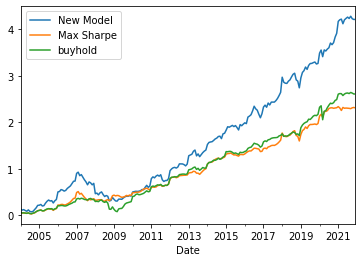

In [15]:
final = cum_returns_simple.resample("M").mean()
final.rename(columns = {'ret_trad':'Max Sharpe', 'ret':'New Model'}, inplace = True)
final.plot()